In [23]:
import numpy as np
import matplotlib.pyplot as plt
import skimage
import pickle
import random
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.measure import regionprops
from pathlib import Path
from skimage.io import imread
from mtcnn import MTCNN
from math import dist

In [2]:
detector = MTCNN()

In [3]:
path = "../../dataset/train/"
path_val = "../../dataset/valid/"
path_test = "../../dataset/test/"

images_path = list(Path(path).rglob(f"*.jpg"))
images_val = list(Path(path_val).rglob(f"*.jpg"))
images_test = list(Path(path_test).rglob(f"*.jpg"))
label_train = [path.parts[-2] for path in images_path]
label_val = [path.parts[-2] for path in images_val]
label_test = [path.parts[-2] for path in images_test]


In [4]:
def calculate_props(im):
    grey = rgb2gray(im)
    trashold = threshold_otsu(grey)
    binary = grey <= trashold
    binary_labeled = skimage.measure.label(binary)
    props = regionprops(binary_labeled)
    max = 0
    index = 0
    for i in range(len(props)):
        if props[i]['area'] > max:
            max = props[i]['area']
            index = i
    return props[index]['area'], props[index]['perimeter'], props[index]['axis_major_length'], props[index]['axis_minor_length'], props[index]['eccentricity']


In [36]:
def distance(p1, p2):
    x = (p1[0]-p2[0])**2
    y = (p1[1]-p2[1])**2
    d = (x+y)**0.5
    return d

In [37]:
def calculate_measures(path):
    measures = []
    index = -1
    im = imread(path)
    im = (skimage.transform.resize(im, (250,250))*255).astype('uint8')
    face = detector.detect_faces(im)
    if len(face) == 1:
        key = face[0]['keypoints']
        #lef eye
        xleye,yleye =key['left_eye']
        l_eye = (xleye,yleye)
        print(l_eye)
        left_eye = im[yleye-10:yleye+10,xleye-20:xleye+20]
        #right eye
        xrey,yrey =key['right_eye']
        r_eye = (xrey,yrey)
        right_eye = im[yrey-10:yrey+10,xrey-20:xrey+20]
        #nose
        xn,yn =key['nose']
        nose_point = (xn,yn)
        nose = im[yn-25:yn+20,xn-30:xn+30]
        #mouth
        xlmo,ylmo =key['mouth_left']
        xrmo,yrmo =key['mouth_right']
        l_mouth = (xlmo,ylmo)
        r_mouth = (xrmo,yrmo)
        y = min(yrmo,ylmo)
        mouth = im[y-20:y+20,xlmo-10:xrmo+10]
        if len(left_eye[0])>0 and len(right_eye[0])>0 and len(nose[0])>0 and len(mouth[0])>0:
            eye_eye = distance(l_eye, r_eye)
            left_eye_nose = distance(l_eye, nose_point)
            right_eye_nose = distance(r_eye, nose_point)
            nose_left_mouth = distance(nose_point, l_mouth)
            nose_right_mouth = distance(nose_point, r_mouth)
            mouth_mouth = distance(l_mouth, r_mouth)
            eye_color_l1 = np.mean(left_eye[:,:,0])
            eye_color_l2 = np.mean(left_eye[:,:,1])
            eye_color_l3 = np.mean(left_eye[:,:,2])
            eye_color_r1 = np.mean(right_eye[:,:,0])
            eye_color_r2 = np.mean(right_eye[:,:,1])
            eye_color_r3 = np.mean(right_eye[:,:,2])
            left_eye1, left_eye2, left_eye3, left_eye4, left_eye5 = calculate_props(left_eye)
            right_eye1, right_eye2, right_eye3, right_eye4, right_eye5 = calculate_props(right_eye)
            nose1, nose2, nose3, nose4, nose5 = calculate_props(nose)
            mouth1, mouth2, mouth3, mouth4, mouth5 = calculate_props(mouth)
            measures = [eye_eye, left_eye_nose, right_eye_nose, nose_left_mouth, nose_right_mouth, mouth_mouth,\
                eye_color_l1, eye_color_l2, eye_color_l3,\
                eye_color_r1, eye_color_r2, eye_color_r3,\
                left_eye1, left_eye2, left_eye3, left_eye4, left_eye5,\
                right_eye1, right_eye2, right_eye3, right_eye4, right_eye5,\
                nose1, nose2, nose3, nose4, nose5,\
                mouth1, mouth2, mouth3, mouth4, mouth5]
                
    return measures

In [9]:
%%capture
measures = []
for i in images_path:
    measure = calculate_measures(i)
    if len(measure)>0:
        measures += [measure]
    else:
        index = images_path.index(i)
        images_path.pop(index)
        label_train.pop(index)


In [12]:
with open("./hand_crafted_features/train_feature.pkl","wb") as handle:
    pickle.dump(measure, handle, pickle.HIGHEST_PROTOCOL)
with open("./hand_crafted_features/train_label.pkl", "wb") as handle:
    pickle.dump(label_train, handle, pickle.HIGHEST_PROTOCOL)
with open("./hand_crafted_features/train_image_path.pkl", "wb") as handle:
    pickle.dump(images_path, handle, pickle.HIGHEST_PROTOCOL)

In [9]:
with open("./hand_crafted_features/train_feature.pkl","rb") as handle:
    measures = pickle.load(handle)
with open("./hand_crafted_features/train_label.pkl", "rb") as handle:
    label_train = pickle.load(handle)
with open("./hand_crafted_features/train_image_path.pkl", "rb") as handle:
    images_path = pickle.load(handle)

In [24]:
%%capture
measures_val = []
for i in images_val:
    measure = calculate_measures(i)
    if len(measure)>0:
        measures_val += [measure]
    else:
        index = images_val.index(i)
        images_val.pop(index)
        label_val.pop(index)

KeyboardInterrupt: 

In [25]:
print(len(images_val))
print(len(label_val))
len(measures_val)

600
600


44

In [ ]:
%%capture
measures_test = []
for i in images_test:
    measure = calculate_measures(i)
    if len(measure)>0:
        measures_test += [measure]
    else:
        index = images_test.index(i)
        images_test.pop(index)
        label_test.pop(index)

In [12]:
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
classifier = svm.NuSVC(nu=0.3,random_state=42)
classifier.fit(measures, label_train)
predicted = classifier.predict(measures_val)
print(classification_report(label_val, predicted))
print(confusion_matrix(label_val, predicted))

              precision    recall  f1-score   support

      savory       0.65      0.62      0.64       300
    unsavory       0.64      0.67      0.65       300

    accuracy                           0.65       600
   macro avg       0.65      0.65      0.64       600
weighted avg       0.65      0.65      0.64       600

[[187 113]
 [100 200]]


In [ ]:
predicted = classifier.predict(measures_test)
print(classification_report(label_test, predicted))
print(confusion_matrix(label_test, predicted))

In [13]:
from sklearn.neighbors import KDTree
import os
tree = KDTree(measures)

In [14]:
def imageSubplot(similar):
    import numpy as np
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))
    for i, path in enumerate(similar):
        plt.subplot(2, 5, i+1)
        plt.axis('off')
        plt.imshow(plt.imread(path))
    plt.show()

1/1 [==============================] - 0s 10ms/step
(91, 113)


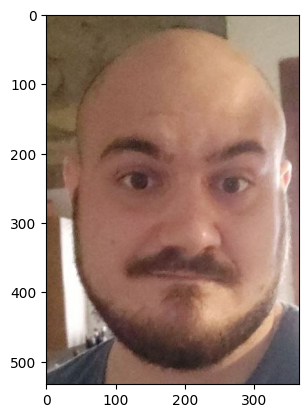

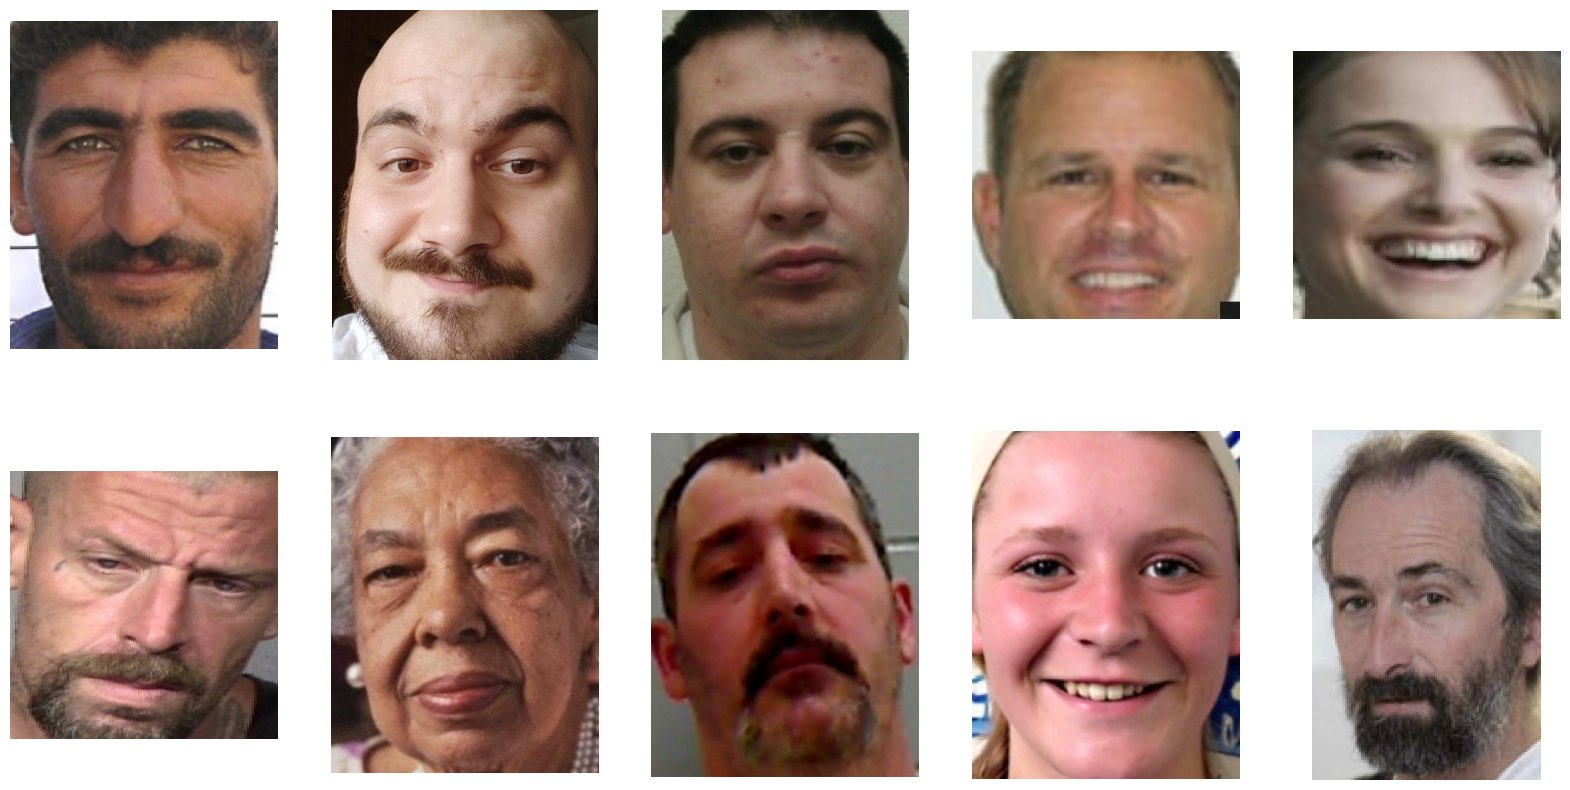

In [48]:
my_photo = "./Test_my_photo/test_pre_after_processed/"
my = list(Path(my_photo).rglob(f"*.jpg"))
for path in my[18:19]:
    img = imread(path)
    feature = calculate_measures(path)
    dist, similar = tree.query([feature], k=10, return_distance=True)
    #imgs_path = [os.path.join(*images_test[j].split('\\')[-2:]) for j in similar[0]]
    imgs_path = [images_path[j] for j in similar[0]]
    plt.figure()
    plt.imshow(img)
    imageSubplot(imgs_path)

In [11]:
images_test

[WindowsPath('../../dataset/test/savory/001.jpg'),
 WindowsPath('../../dataset/test/savory/002.jpg'),
 WindowsPath('../../dataset/test/savory/003.jpg'),
 WindowsPath('../../dataset/test/savory/004.jpg'),
 WindowsPath('../../dataset/test/savory/005.jpg'),
 WindowsPath('../../dataset/test/savory/006.jpg'),
 WindowsPath('../../dataset/test/savory/007.jpg'),
 WindowsPath('../../dataset/test/savory/008.jpg'),
 WindowsPath('../../dataset/test/savory/009.jpg'),
 WindowsPath('../../dataset/test/savory/010.jpg'),
 WindowsPath('../../dataset/test/savory/011.jpg'),
 WindowsPath('../../dataset/test/savory/012.jpg'),
 WindowsPath('../../dataset/test/savory/013.jpg'),
 WindowsPath('../../dataset/test/savory/014.jpg'),
 WindowsPath('../../dataset/test/savory/015.jpg'),
 WindowsPath('../../dataset/test/savory/016.jpg'),
 WindowsPath('../../dataset/test/savory/017.jpg'),
 WindowsPath('../../dataset/test/savory/018.jpg'),
 WindowsPath('../../dataset/test/savory/019.jpg'),
 WindowsPath('../../dataset/tes

In [43]:
imgs_path = [images_path[j] for j in similar[0]]


..\..\dataset\train\unsavory\0310.jpg


array([ 5962,  8068,  7826,  8987,  2121,  2643,  1507, 10450,  2925,
        3618], dtype=int64)

In [35]:
for j in similar[0]:
    print(j)
    print(images_path[j])

5962
..\..\dataset\train\unsavory\0310.jpg
8068
..\..\dataset\train\unsavory\2420.jpg
7826
..\..\dataset\train\unsavory\2176.jpg
8987
..\..\dataset\train\unsavory\3342.jpg
2121
..\..\dataset\train\savory\2127.jpg
2643
..\..\dataset\train\savory\2650.jpg
1507
..\..\dataset\train\savory\1510.jpg
10450
..\..\dataset\train\unsavory\4808.jpg
2925
..\..\dataset\train\savory\2932.jpg
3618
..\..\dataset\train\savory\3626.jpg
